In [3]:
import numpy as np
import pandas as pd
from math import e
from sklearn.datasets import load_breast_cancer
from matplotlib import pyplot as plt
import seaborn as sns # for correlation heatmap
data = load_breast_cancer(as_frame=True)
x=data.data

In [4]:
class Node:
    split_imp=dict()
    for i in range(x.shape[1]): 
      split_imp[i]=0
    '''
    A node object that is recursivly called within itslef to construct a regression tree. Based on Tianqi Chen's XGBoost 
    the internal gain used to find the optimal split value uses both the gradient and hessian. Also a weighted quantlie sketch 
    and optimal leaf values all follow Chen's description in "XGBoost: A Scalable Tree Boosting System" the only thing not 
    implemented in this version is sparsity aware fitting or the ability to handle NA values with a default direction.
    Inputs
    ------------------------------------------------------------------------------------------------------------------
    x: pandas datframe of the training data
    gradient: negative gradient of the loss function
    hessian: second order derivative of the loss function
    idxs: used to keep track of samples within the tree structure
    subsample_cols: is an implementation of layerwise column subsample randomizing the structure of the trees
    (complexity parameter)
    min_leaf: minimum number of samples for a node to be considered a node (complexity parameter)
    min_child_weight: sum of the heassian inside a node is a meaure of purity (complexity parameter)
    depth: limits the number of layers in the tree
    lambda: L2 regularization term on weights. Increasing this value will make model more conservative.
    gamma: This parameter also prevents over fitting and is present in the the calculation of the gain (structure score). 
    As this is subtracted from the gain it essentially sets a minimum gain amount to make a split in a node.
    eps: This parameter is used in the quantile weighted skecth or 'approx' tree method roughly translates to 
    (1 / sketch_eps) number of bins
    Outputs
    --------------------------------------------------------------------------------------------------------------------
    A single tree object that will be used for gradient boosintg.
    '''

    def __init__(self, x, gradient, hessian, idxs, subsample_cols = 0.8 , min_leaf = 5, min_child_weight = 1 ,depth = 10, lambda_ = 1, gamma = 1, eps = 0.1):
      
        self.x, self.gradient, self.hessian = x, gradient, hessian
        self.idxs = idxs 
        self.depth = depth
        self.min_leaf = min_leaf
        self.lambda_ = lambda_
        self.gamma  = gamma
        self.min_child_weight = min_child_weight
        self.row_count = len(idxs)
        self.col_count = x.shape[1]
        self.subsample_cols = subsample_cols
        self.eps = eps
        self.column_subsample = np.random.permutation(self.col_count)[:round(self.subsample_cols*self.col_count)]
        self.val = self.compute_gamma(self.gradient[self.idxs], self.hessian[self.idxs])
        self.score = float('-inf')
        self.find_varsplit()
        
        
    def compute_gamma(self, gradient, hessian):
        '''
        Calculates the optimal leaf value equation (5) in "XGBoost: A Scalable Tree Boosting System"
        '''
        return(-np.sum(gradient)/(np.sum(hessian) + self.lambda_))
        
    def find_varsplit(self):
        '''
        Scans through every column and calcuates the best split point.
        The node is then split at this point and two new nodes are created.
        Depth is only parameter to change as we have added a new layer to tre structure.
        If no split is better than the score initalised at the begining then no splits further splits are made
        '''
        for c in self.column_subsample: 
          self.find_greedy_split(c) ## features sampled
        # print(self.score)     
        if self.is_leaf: return
        x = self.split_col
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        self.lhs = Node(x = self.x, gradient = self.gradient, hessian = self.hessian, idxs = self.idxs[lhs], min_leaf = self.min_leaf, depth = self.depth-1, lambda_ = self.lambda_ , gamma = self.gamma, min_child_weight = self.min_child_weight, eps = self.eps, subsample_cols = self.subsample_cols)
        self.rhs = Node(x = self.x, gradient = self.gradient, hessian = self.hessian, idxs = self.idxs[rhs], min_leaf = self.min_leaf, depth = self.depth-1, lambda_ = self.lambda_ , gamma = self.gamma, min_child_weight = self.min_child_weight, eps = self.eps, subsample_cols = self.subsample_cols)
    def find_greedy_split(self, var_idx):
        '''
         For a given feature greedily calculates the gain at each split.
         Globally updates the best score and split point if a better split point is found
        '''
        x = self.x.values[self.idxs, var_idx]
        # print('var_idx',var_idx)
        for r in range(self.row_count):
            lhs = x <= x[r]
            rhs = x > x[r]
            
            lhs_indices = np.nonzero(x <= x[r])[0]
            rhs_indices = np.nonzero(x > x[r])[0]
            if(rhs.sum() < self.min_leaf or lhs.sum() < self.min_leaf 
               or self.hessian[lhs_indices].sum() < self.min_child_weight
               or self.hessian[rhs_indices].sum() < self.min_child_weight): continue

            curr_score = self.gain(lhs, rhs)
            if curr_score > self.score: 
                self.var_idx = var_idx
                self.score = curr_score
                self.split = x[r]
        
    def weighted_qauntile_sketch(self, var_idx):
        '''
        XGBOOST Mini-Version
        Yiyang "Joe" Zeng
        Is an approximation to the eact greedy approach faster for bigger datasets wher it is not feasible
        to calculate the gain at every split point. Uses equation (8) and (9) from "XGBoost: A Scalable Tree Boosting System"
        '''
        x = self.x.values[self.idxs, var_idx]
        hessian_ = self.hessian[self.idxs]
        df = pd.DataFrame({'feature':x,'hess':hessian_})
        
        df.sort_values(by=['feature'], ascending = True, inplace = True)
        hess_sum = df['hess'].sum() 
        df['rank'] = df.apply(lambda x : (1/hess_sum)*sum(df[df['feature'] < x['feature']]['hess']), axis=1)
        
        for row in range(df.shape[0]-1):
            # look at the current rank and the next ran
            rk_sk_j, rk_sk_j_1 = df['rank'].iloc[row:row+2]
            diff = abs(rk_sk_j - rk_sk_j_1)
            if(diff >= self.eps):
                continue
                
            split_value = (df['rank'].iloc[row+1] + df['rank'].iloc[row])/2
            lhs = x <= split_value
            rhs = x > split_value
            
            lhs_indices = np.nonzero(x <= split_value)[0]
            rhs_indices = np.nonzero(x > split_value)[0]
            if(rhs.sum() < self.min_leaf or lhs.sum() < self.min_leaf 
               or self.hessian[lhs_indices].sum() < self.min_child_weight
               or self.hessian[rhs_indices].sum() < self.min_child_weight): continue
                
            curr_score = self.gain(lhs, rhs)
            if curr_score > self.score: 
                self.var_idx = var_idx
                self.score = curr_score
                self.split = split_value
                
    def gain(self, lhs, rhs):
        '''
        Calculates the gain at a particular split point bases on equation (7) from
        "XGBoost: A Scalable Tree Boosting System"
        '''
        gradient = self.gradient[self.idxs]
        hessian  = self.hessian[self.idxs]
        
        lhs_gradient = gradient[lhs].sum()
        lhs_hessian  = hessian[lhs].sum()
        
        rhs_gradient = gradient[rhs].sum()
        rhs_hessian  = hessian[rhs].sum()
        
        gain = 0.5 *( (lhs_gradient**2/(lhs_hessian + self.lambda_)) + (rhs_gradient**2/(rhs_hessian + self.lambda_)) - ((lhs_gradient + rhs_gradient)**2/(lhs_hessian + rhs_hessian + self.lambda_))) - self.gamma
        return(gain)
                
    @property
    def split_col(self):
        '''
        splits a column 
        '''
        print(self.var_idx)
        Node.split_imp[self.var_idx]=Node.split_imp[self.var_idx]+1 ## calculate imp by split
        print(Node.split_imp)
        return self.x.values[self.idxs , self.var_idx]
                
    @property
    def is_leaf(self):
        '''
        checks if node is a leaf
        '''
        return self.score == float('-inf') or self.depth <= 0                 

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])
    
    def predict_row(self, xi):
        if self.is_leaf:
            return(self.val)

        node = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return node.predict_row(xi)


In [5]:
class XGBoostTree:
    '''
    Wrapper class that provides a scikit learn interface to the recursive regression tree above
    
    Inputs
    ------------------------------------------------------------------------------------------------------------------
    x: pandas datframe of the training data
    gradient: negative gradient of the loss function
    hessian: second order derivative of the loss function
    idxs: used to keep track of samples within the tree structure
    subsample_cols: is an implementation of layerwise column subsample randomizing the structure of the trees
    (complexity parameter)
    min_leaf: minimum number of samples for a node to be considered a node (complexity parameter)
    min_child_weight: sum of the heassian inside a node is a meaure of purity (complexity parameter)
    depth: limits the number of layers in the tree
    lambda: L2 regularization term on weights. Increasing this value will make model more conservative.
    gamma: This parameter also prevents over fitting and is present in the the calculation of the gain (structure score). 
    As this is subtracted from the gain it essentially sets a minimum gain amount to make a split in a node.
    eps: This parameter is used in the quantile weighted skecth or 'approx' tree method roughly translates to 
    (1 / sketch_eps) number of bins
    
    Outputs
    --------------------------------------------------------------------------------------------------------------------
    A single tree object that will be used for gradient boosintg.
    
    '''
    def fit(self, x, gradient, hessian, subsample_cols = 0.8 , min_leaf = 5, min_child_weight = 1 ,depth = 10, lambda_ = 1, gamma = 1, eps = 0.1):
        self.dtree = Node(x, gradient, hessian, np.array(np.arange(len(x))), subsample_cols, min_leaf, min_child_weight, depth, lambda_, gamma, eps)        
        return self
    def predict(self, X):
        return self.dtree.predict(X.values)
    # def fe_imp_split(self):
    #     return self.dtree.split_imp

In [6]:
class XGBoostClassifier:
    '''
    Full application of the XGBoost algorithm as described in "XGBoost: A Scalable Tree Boosting System" for 
    Binary Classification.
    Inputs
    ------------------------------------------------------------------------------------------------------------------
    x: pandas datframe of the training data
    gradient: negative gradient of the loss function
    hessian: second order derivative of the loss function
    idxs: used to keep track of samples within the tree structure
    subsample_cols: is an implementation of layerwise column subsample randomizing the structure of the trees
    (complexity parameter)
    min_leaf: minimum number of samples for a node to be considered a node (complexity parameter)
    min_child_weight: sum of the heassian inside a node is a meaure of purity (complexity parameter)
    depth: limits the number of layers in the tree
    lambda: L2 regularization term on weights. Increasing this value will make model more conservative.
    gamma: This parameter also prevents over fitting and is present in the the calculation of the gain (structure score). 
    As this is subtracted from the gain it essentially sets a minimum gain amount to make a split in a node.
    eps: This parameter is used in the quantile weighted skecth or 'approx' tree method roughly translates to 
    (1 / sketch_eps) number of bins
    Outputs
    --------------------------------------------------------------------------------------------------------------------
    A single tree object that will be used for gradient boosintg.
    '''
    def __init__(self):
        self.estimators = []
    
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    # first order gradient logLoss
    def grad(self, preds, labels):
        preds = self.sigmoid(preds)
        return(preds - labels)
    
    # second order gradient logLoss
    def hess(self, preds, labels):
        preds = self.sigmoid(preds)
        return(preds * (1 - preds))
    
    @staticmethod
    def log_odds(column):
        binary_yes = np.count_nonzero(column == 1)
        binary_no  = np.count_nonzero(column == 0)
        return(np.log(binary_yes/binary_no))
    
    
    def fit(self, X, y, subsample_cols = 0.8 , min_child_weight = 1, depth = 5, min_leaf = 5, learning_rate = 0.4, boosting_rounds = 5, lambda_ = 1.5, gamma = 1, eps = 0.1):
        self.X, self.y = X, y.values
        self.depth = depth
        self.subsample_cols = subsample_cols
        self.eps = eps
        self.min_child_weight = min_child_weight 
        self.min_leaf = min_leaf
        self.learning_rate = learning_rate
        self.boosting_rounds = boosting_rounds 
        self.lambda_ = lambda_
        self.gamma  = gamma
        # self.feature_importance_split = {}
        self.base_pred = np.full((X.shape[0], 1), 1).flatten().astype('float64')
    
        for booster in range(self.boosting_rounds):
            Grad = self.grad(self.base_pred, self.y)
            Hess = self.hess(self.base_pred, self.y)
            clf=XGBoostTree()
            boosting_tree = clf.fit(self.X, Grad, Hess, depth = self.depth, min_leaf = self.min_leaf, lambda_ = self.lambda_, gamma = self.gamma, eps = self.eps, min_child_weight = self.min_child_weight, subsample_cols = self.subsample_cols)
            self.base_pred += self.learning_rate * boosting_tree.predict(self.X)
            self.estimators.append(boosting_tree)
            # self.feature_importance_split = clf.fe_imp_split() ## feature importance split
    def predict_proba(self, X):
        pred = np.zeros(X.shape[0])
        
        for estimator in self.estimators:
            pred += self.learning_rate * estimator.predict(X) 
          
        return(self.sigmoid(np.full((X.shape[0], 1), 1).flatten().astype('float64') + pred))
    
    def predict(self, X):
        pred = np.zeros(X.shape[0])
        for estimator in self.estimators:
            pred += self.learning_rate * estimator.predict(X) 
        
        predicted_probas = self.sigmoid(np.full((X.shape[0], 1), 1).flatten().astype('float64') + pred)
        preds = np.where(predicted_probas > np.mean(predicted_probas), 1, 0)
        return(preds)


In [7]:
from sklearn.datasets import load_breast_cancer
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns # for correlation heatmap
data = load_breast_cancer(as_frame=True)
x=data.data
y=data.target

7
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0}
20
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 1, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0}
1
{0: 0, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 1, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0}
21
{0: 0, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 1, 21: 1, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0}
22
{0: 0, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 1, 21: 1, 22: 1, 23: 0, 24: 0, 25: 0, 26: 0, 27:

<BarContainer object of 30 artists>

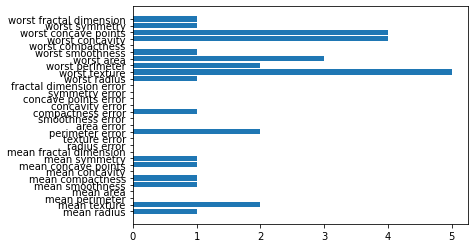

In [8]:
model = XGBoostClassifier()
model.fit(x.iloc[0:400,:], y[0:400], min_leaf=5, depth=3)
imp_=Node.split_imp # dict track the feature importance
plt.barh(data.feature_names, imp_.values()) ## plot feature importance plot (split)